In [179]:
# !pip install langchain langchain-comminity langchain_openai langchain-anthropic tavily-python langchain-experimental

In [180]:
import os
import keyring

# API KEY
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'blogbot')
os.environ['LANGCHAIN_PROJECT'] = "proj-blog-bot"

In [181]:
## Tools
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities.python import PythonREPL


tavily_tool = TavilySearchResults(max_results=5)

repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate chart."],
):
    """Use this to execute python code and do match. 
    If you want to see the output of a value,
    you should print it out with `print(....)`. This is visible to user.
    """
    try:
        result = repr.run(code)
    except Exception as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Sucessfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [182]:
# Create Supervisor
import json

from typing import Literal, List, Optional, Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

members = ["planner", "researcher", "coder", "writer"]
options = members + ["FINISH"]

system_prompt = """ 
You are a supervisor managing a blog posting team responsible for **researching topics, gathering data, writing, and structuring blog posts**. 
Your team consists of the following specialists:
{members}

Your primary responsibility is to **assign tasks to the most suitable specialist based on their expertise** and **ensure the quality of their output**.

---

## **🔹 Instructions**
- **Always respond in English.**
- Assign tasks to the **most appropriate** specialist based on their role.
- Ensure the process is **efficient and iterative**, refining outputs when necessary.

---

## **🔹 Member Roles & Responsibilities**
1. **planner** – Analyzes the user’s subject and outlines key topics for research.
2. **researcher** – Gathers credible sources, factual data, and background information.
3. **coder** – Implements any necessary code snippets or technical explanations.
4. **writer** – Drafts, structures, and refines the final blog post.

---

## **🔹 Responsibilities**
### **1. Manage Task Assignment**
- Evaluate the **subject** provided by the user and determine which specialist should act every step.
  - If you need to make outlines for a blog post, call "planner".
  - If you need to research data and sources, call "researcher".
  - If you think code snippets are necessary, call "coder". 
  - If you think outline, research and code snippets are ready, call "writer". 
  - When all completed, call "FINISH".
- Monitor the **progress** of plan, research, writing, and content structuring.
- If any member’s output is **incomplete or lacks quality**, request refinements.

### **2. Evaluate Outputs**
- Review the **work** submitted by each specialist.
- Determine whether each step has been **adequately completed** with sufficient depth and clarity.
- Ensure all gathered information is well-structured and relevant to the blog post.

### **3. Complete the Process**
- Once the **blog post is fully written and reviewed**, respond with `"FINISH"` to conclude the task.

---

## **🔹 Output Format**
Respond with a **valid JSON object** formatted as follows:
**NEVER INCLUDE OTHER TEXTS IN THE OUTPUT** Include just json format.
```
{
    "next": "researcher",  // Replace with "planner", "coder", "writer", or "FINISH"
    "instructions": "Provide additional research on AI trends in 2024."
}
"""

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH"""
    
    next: Literal["planner", "researcher", "coder", "writer", "FINISH"]
    instructions: str
    
llm_anthropic = ChatAnthropic(model="claude-3-5-haiku-latest", temperature=0.5)
llm_openai = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

class State(TypedDict):
    """Defines the state of the multi-agent blog writing process."""

    # Stores conversation messages (chat history)
    messages: Annotated[List[BaseMessage], add_messages]  

    # Stores collected research materials (articles, references)
    docs: Optional[str]
    
    # Stores generated code snippets
    code: Optional[str]  
    
    # Stores a generated outline
    outline: Optional[str]
    
    
    # Stores the draft or final version of the blog post
    post: Optional[str]  # ✅ Optional for iterative updates
    
    # Determines which agent should act next (planner, researcher, coder, writer, or FINISH)
    next: Literal["planner", "research", "coder", "writer", "FINISH"]
    
    # Stores specific instructions for the next agent
    instructions: Optional[str]  # ✅ Optional to prevent KeyError when missing

In [183]:
def supervisor_node(state: State):
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm_anthropic.invoke(messages)
    print(response)
    parsed_response = json.loads(response.content)
    goto = parsed_response["next"]
    if parsed_response["instructions"]:
        instructions = parsed_response.get("instructions", "No instructions provided.")
    if goto == "FINISH":
        goto = END
    # Append instructions to message to maintain full context
    # updated_messages = state["messages"] + [HumanMessage(content=instructions, name="supervisor")]
    
    return Command(goto=goto, update={"messages": HumanMessage(content=instructions, name="supervisor"), "next":goto, "instructions": instructions})

In [184]:
# Planner

planner_prompt = """
You are a **blog planner** responsible for structuring and organizing a high-quality blog post. 

## **🔹 Instructions**
- **Always respond in English.**
- Analyze the given topic and define a **clear structure** for the blog post.
- Identify key sections, subtopics, and any necessary research or code that might be needed.
- Provide clear **instructions** for the research, coding, and writing teams.

---

## **🔹 Responsibilities**
### **1. Define Blog Objectives**
- Clearly define the **purpose** and **target audience** of the blog post.
- Identify **key topics** that should be covered.

### **2. Outline Blog Structure**
- Break down the blog into **logical sections** (Introduction, Main Content, Conclusion, etc.).
- Indicate which sections require **research** or **code examples**.

### **3. Assign Tasks**
- Specify which tasks should be assigned to **researchers, coders, and writers**.
- If unsure, assign tasks to the **general** research team.

---

## **🔹 Output**
Respond output as follows:

# Title
<Blog Post Title>

# Objectives
<Main purpose of the blog post>

# Outlines
<Section 1 - Description>
<Section 2 - Description>
<Section 3 - Description>
...
"""

planner_agent = create_react_agent(llm_openai, tools=[tavily_tool], state_modifier=planner_prompt)

def planner_node(state: State):
    
    """The planner defines the blog post structure"""
    results = planner_agent.invoke({"messages": state["messages"][-1]})
    
    return {
        # "messages": state["messages"] + [new_message],
        "messages": HumanMessage(content=results["messages"][-1].content, name="planner"),
        "next": "supervisor", 
        "outline": results["messages"][-1].content, 
    }
    

In [185]:
# Researcher
researcher_prompt = """ 
You are a **research specialist** responsible for gathering and verifying **reliable information** for a blog post.

## **🔹 Instructions**
- **Always respond in the same language as the blog topic.**
- Use **credible sources** (e.g., research papers, news articles, official reports).
- **Summarize** key findings concisely.
- Provide **direct links** to sources.

---

## **🔹 Responsibilities**
### **1. Gather Relevant Information**
- Research the topics assigned by the planner.
- Ensure **accuracy and credibility** of sources.

### **2. Summarize Key Insights**
- Extract **essential facts, statistics, or quotes**.
- Summarize findings in **clear and simple language**.

### **3. Provide Sources**
- List **direct links** to the original sources.
"""

researcher_agent = create_react_agent(llm_openai, tools=[tavily_tool], state_modifier=researcher_prompt)

def researcher_node(state: State):
    """The Researcher gathers factual information and updates the state with references."""
    research_chain = researcher_agent | StrOutputParser()
    results = research_chain.invoke({"messages": state["messages"]})
    
    return {"next": "supervisor", "messages": HumanMessage(content=results["messages"][-1].content, name="researcher"), "docs": results["messages"][-1].content}


In [186]:
# Coder

coder_prompt = """
You are a **software developer** responsible for providing well-documented **code examples** for a blog post.

## **🔹 Instructions**
- **Always respond in the same language as the blog topic.**
- Generate **readable, efficient, and well-commented** code snippets.
- Ensure code is **error-free and follows best practices**.
- Provide a brief **explanation** for each snippet.

---

## **🔹 Responsibilities**
### **1. Generate Code Snippets**
- Write **concise and functional** code relevant to the blog topic.
- Ensure proper **syntax and formatting**.

### **2. Explain Code**
- Provide a **step-by-step explanation** of how the code works.
- Highlight **key concepts** and **best practices**.

### **3. Ensure Readability**
- Use **comments** within the code for clarity.

---

## **🔹 Output Format**

# Topic
<Coding Topic>

# Code Snippet
```<Formatted Code Block>```

# Explanation
<Brief explanation of the code>
}
"""

coder_agent = create_react_agent(llm_openai, tools=[tavily_tool], state_modifier=coder_prompt)

def coder_node(state: State):
    """The Coder generates code snippets if required."""
    
    results = coder_agent.invoke(state["messages"])
    
    return {"next": "supervisor", "messages": HumanMessage(content=results["messages"][-1].content, name="coder"), "codes": results["messages"][-1].content}

In [187]:
# Writer

writer_prompt = """
You are a **blog writer** responsible for crafting an engaging and well-structured blog post.

## **🔹 Instructions**
- **Always write in an engaging and informative tone.**
- Integrate **research findings, code snippets, and planner instructions** into a well-structured article.
- Use **clear headings**, **bullet points**, and **examples** to improve readability.

---

## **🔹 Responsibilities**
### **1. Draft the Blog Post**
- Follow the planner’s **structure and objectives**.
- Ensure the content flows **logically and cohesively**.

### **2. Incorporate Research & Code**
- Seamlessly integrate **research findings** and **code snippets** into the blog.
- Explain technical concepts in **simple language**.

### **3. Ensure Readability & Engagement**
- Use **short paragraphs**, **headings**, and **examples** for clarity.
- Make the content **engaging and easy to understand**.

## Planner outlines
{outlines}

## Researches
{docs}

## Code snippet
{codes}

## **🔹 Output Format**
Write the blog post in **Markdown format**. 
Use appropriate **headings (#, ##, ###), lists (-, *), bold text (**bold**), italics (*italics*), and code blocks (```python ... ```) where needed.
"""

writer_agent = create_react_agent(llm_anthropic, tools=[tavily_tool], state_modifier=writer_prompt)

def writer_node(state: State):
    
    write_chain = writer_prompt.format(outlines=state["sections"], docs=state["docs"], codes=state["code"]) | llm_anthropic
    results = write_chain.invoke(state)
    
    return {"messages": HumanMessage(content=results.content, name="writer"), "post": results.content, "next": "supervisor"}
    

In [188]:
# Build graph

builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("planner", planner_node)
builder.add_node("researcher", researcher_node)
builder.add_node("coder", coder_node)
builder.add_node("writer", writer_node)
builder.add_edge(START, "supervisor")
for member in members:
    builder.add_edge(member, "supervisor")
graph = builder.compile()

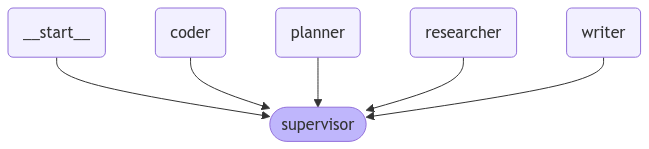

In [189]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [190]:
for s in graph.stream(
    {"messages": [("user", "Write a blog post about DeepSeek-R1")]}
):
    print(s)
    print("---")

content='{\n    "next": "planner",\n    "instructions": "Create an outline for a blog post about DeepSeek-R1, covering its key features, technological innovations, and potential impact in the AI landscape."\n}' additional_kwargs={} response_metadata={'id': 'msg_01Ctwmt2FjtCa1LcDUeEegdx', 'model': 'claude-3-5-haiku-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 604, 'output_tokens': 53}} id='run-c2ce2c03-5b01-4166-ad4e-c2968ddd4624-0' usage_metadata={'input_tokens': 604, 'output_tokens': 53, 'total_tokens': 657, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}}
{'supervisor': {'messages': HumanMessage(content='Create an outline for a blog post about DeepSeek-R1, covering its key features, technological innovations, and potential impact in the AI landscape.', additional_kwargs={}, response_metadata={}, name='supervisor', id='e36016a5-4c6b-4fa2-868a-65cb33081dd6'), 'next': 

KeyboardInterrupt: 